In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
base_data_dir = './data'

In [3]:
latest_data_dir_num = max([int(dir.split('_')[-1]) for dir in os.listdir(base_data_dir) if dir.split('_')[-1].isdigit()])
data_dir = [dir for dir in os.listdir(base_data_dir) if dir.split('_')[-1].isdigit() and int(dir.split('_')[-1]) == latest_data_dir_num][0]
data_dir = f'{base_data_dir}/{data_dir}'

In [4]:
data_dir

'./data/decoded_data_56'

In [5]:
import h5py

In [6]:
with h5py.File(f'{data_dir}/final_images.h5') as f:
    images = f['final_images'][:].squeeze()

with h5py.File(f'{data_dir}/final_labels.h5') as f:
    labels = f['final_labels'][:]

In [7]:
def normalize_images(imgs):
    imgs -= imgs.min()
    imgs /= imgs.max()
    imgs *= 255
    return imgs

In [15]:
# original shape of images from augmentation notebook is 10242
original_images_factor = images.shape[0] // 10242
generated_images_start_idx = images.shape[0] // original_images_factor

In [8]:
# images = images.astype(np.float32)
images[generated_images_start_idx:] = normalize_images(images[generated_images_start_idx:])
images = images.astype(np.uint8)

In [9]:
images[generated_images_start_idx:].min(), images[generated_images_start_idx:].max()

(0, 255)

In [10]:
images.shape

(30726, 176, 144)

In [11]:
U, S, V_t = np.linalg.svd(images.reshape(images.shape[0], -1), full_matrices=False)

In [12]:
k = int(0.05 * images.shape[0])

In [13]:
svd_images = U[:, :k] @ (np.diag(S[:k]) @ V_t[:k, :])
svd_images = svd_images.reshape(*images.shape)

In [16]:
svd_images[generated_images_start_idx:].min(), svd_images[generated_images_start_idx:].max()

(-25.11876847842062, 237.4729647833665)

In [17]:
svd_images = normalize_images(svd_images)
svd_images = svd_images.astype(np.uint8)

Text(0.5, 1.0, 'Generated Image After SVD')

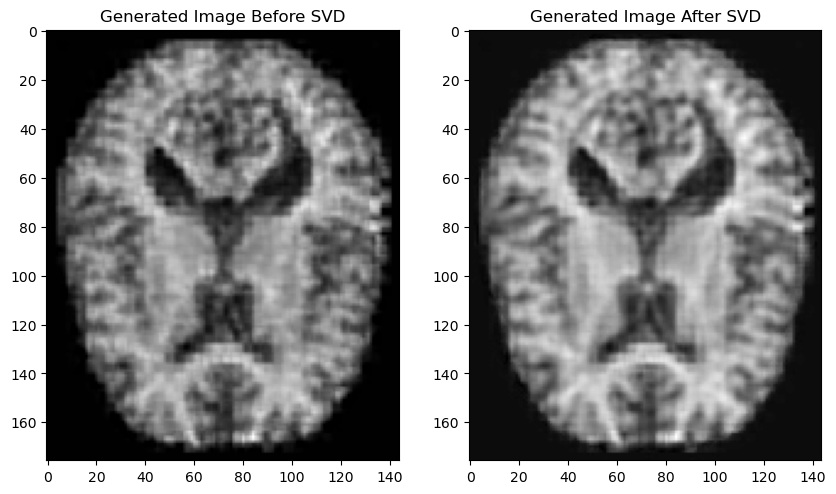

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(images[-1], cmap='gray')
axes[0].set_title('Generated Image Before SVD')
axes[1].imshow(svd_images[-1], cmap='gray')
axes[1].set_title('Generated Image After SVD')

In [19]:
images[generated_images_start_idx:].max(), images[generated_images_start_idx:].min()

(255, 0)

In [20]:
images[generated_images_start_idx:] = svd_images[generated_images_start_idx:]

In [21]:
data_dir='./data/alzheimer/train'
classes = os.listdir(data_dir)

In [22]:
import seaborn as sns

In [23]:
def transform_image(image, threshold=None, return_inverse=False):
    fft_image = np.fft.fft2(image)
    if threshold is None:
        threshold = 0.0000005 * np.abs(fft_image)
    # creating a mask for zeroing low amplitudes, i.e: below the threshold
    mask = np.ones_like(fft_image)
    mask[np.abs(fft_image) <= threshold] = 0
    filtered_fft_image = fft_image * mask
    # getting the inverse fourier transform on the filtered image
    inverse_fft_image = np.fft.ifft2(filtered_fft_image)
    transformed_image = np.real(inverse_fft_image * np.conj(inverse_fft_image))
    # normalizing to [0, 255] range
    transformed_image = transformed_image / transformed_image.max()
    transformed_image *= 255
    if return_inverse:
        return fft_image, transformed_image
    return transformed_image

def filter(inverse):
    ones = np.ones_like(inverse)
    epsilon = 0.000001
    border = 0
    center_y, center_x = ones.shape[0]//2, ones.shape[1]//2
    center = np.array([center_y, center_x])

    ones[center_y-border:center_y+border+1, center_x-border:center_x+border+1] = 0 + epsilon
    v, u = np.mgrid[:inverse.shape[0], :inverse.shape[1]]

    distances_from_center = np.sqrt(
        np.square(v - center[0]) + np.square(u - center[1])
    )
    threshold = 40
    mask = distances_from_center <= threshold

    return inverse * mask

## Fine tuning the autoencoder model

In [24]:
import torch
import torch.nn as nn

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
import modules.models
from modules.models.models import ConvClassifier
from modules.models.dataset import AlzheimerDataset

In [27]:
import modules.db
from modules.db.optuna_report import get_best_hyperparameters

In [28]:
perm = torch.randperm(images.shape[0])
val_indices = perm[:int(images.shape[0] * 0.15)].numpy()
train_indices = np.setdiff1d(np.arange(images.shape[0]), val_indices)

In [29]:
# using the same training and validation datasets from the autoencoder training
train_dataset = AlzheimerDataset(images[train_indices], labels[train_indices])
val_dataset = AlzheimerDataset(images[val_indices], labels[val_indices])

In [30]:
params = get_best_hyperparameters(from_last_study=False) # get hyperparameters from the study, if studied

train_best_params = params
train_best_params['lr'] = train_best_params['learning_rate']

In [31]:
def train_epoch(model, optimizer, loss, dataloader, val_dataset, overall_losses, val_overall_losses, accuracy, val_accuracy, epoch, scheduler=None, writer=None):
    for _, (batch_X, batch_y) in enumerate(dataloader):
        batch_X = batch_X.to(device=model.device)
        batch_y = batch_y.to(device=model.device)

        if batch_X.shape[0] == 1:
            batch_X = torch.concat((batch_X, batch_X), dim=0).to(device=model.device)
            batch_y = torch.concat((batch_y, batch_y), dim=0).to(device=model.device)
        
        optimizer.zero_grad()
        
        batch_output = model(batch_X)
        batch_loss = loss(batch_output, batch_y)
        overall_losses[epoch] += batch_loss.item()

        predictions = torch.argmax(batch_output, dim=1).to(model.device)
        accuracy[epoch] += (predictions == batch_y).sum().item()
    
        batch_loss.backward()
        optimizer.step()
    
    # updating train metrics
    overall_losses[epoch] /= dataloader.dataset.y.shape[0]
    accuracy[epoch] /= dataloader.dataset.y.shape[0]

    if writer:
        writer.add_scalar('Overall Loss/Train', overall_losses[epoch], epoch)
        writer.add_scalar('Accuracy/Train', accuracy[epoch], epoch)
        
    # validation
    with torch.no_grad():
        model.eval()
        val_output = model(val_dataset.X.to(model.device))
        loss_value = loss(val_output, val_dataset.y.to(model.device))

        val_overall_losses[epoch] = loss_value.item() / val_dataset.y.shape[0]

        predictions = torch.argmax(val_output, dim=1).to(model.device)
        val_accuracy[epoch] = (predictions == val_dataset.y.to(model.device)).sum().item() / predictions.shape[0]

        if writer:
            writer.add_scalar('Overall Loss/Validation', val_overall_losses[epoch], epoch)
            writer.add_scalar('Accuracy/Validation', val_accuracy[epoch], epoch)

    # update learning rate after each epoch to have equal effect for every batch
    if scheduler is not None:
        scheduler.step()
    

In [32]:
from tqdm.notebook import tqdm

In [33]:
import modules.db
from modules.db.optuna_report import report_optuna_trial, get_last_study_id

In [34]:
from torch.utils.tensorboard import SummaryWriter
import optuna

In [35]:
classification_studies_dir = './data/studies/classification'
if not os.path.isdir(classification_studies_dir):
    os.mkdir(classification_studies_dir)
studies_directories = os.listdir(classification_studies_dir)
# if last study wasn't finished, use that study id in tensorboard and later on in resuming the optuna study
if len(studies_directories) > 0:
    current_study_id = studies_directories[-1].split('-')[-1]
# last study finished successfully so we'll start a brand new one
else:
    current_study_id = get_last_study_id()
current_study_id

67

In [36]:
# if trial is None we're going for multi-objective optimization or we're normally training
def train(trial, model, optimizer, loss, epochs, dataloader, val_dataset, scheduler=None, plot=True, show_progress=True):
    log_dir = f'./logs/classification/study-{current_study_id}/trial-{trial.number}' if trial else f'./logs/classification/study-{current_study_id}/final'
    writer = SummaryWriter(log_dir=log_dir)

    writer.add_graph(model, next(iter(dataloader))[0].to(device=model.device))
    
    overall_losses, val_overall_losses = torch.zeros(epochs), torch.zeros(epochs)
    accuracy, val_accuracy = torch.zeros(epochs), torch.zeros(epochs)
    
    # using tqdm has conflicts with optuna's study progress bar
    epochs_range = tqdm(range(epochs)) if show_progress else range(epochs)
    for epoch in epochs_range:
        model.train()
        
        train_epoch(
            model=model,
            optimizer=optimizer, 
            loss=loss,
            epoch=epoch,
            dataloader=dataloader,
            val_dataset=val_dataset,
            val_overall_losses=val_overall_losses,
            accuracy=accuracy,
            val_accuracy=val_accuracy,
            overall_losses=overall_losses,
            scheduler=scheduler,
            writer=writer
        )

        writer.flush()
        
        if trial is not None:
            trial.report(overall_losses[epoch].item(), epoch)

            if trial.should_prune():
                writer.close()
                raise optuna.TrialPruned()

    if plot:
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(16, 10))
        
        axes[0].plot(overall_losses.cpu(), color='blue', label='Train')
        axes[0].plot(val_overall_losses.cpu(), color='orange', label='Validation')
        axes[0].set_title('Overall Loss')
        axes[0].legend()

        axes[1].plot(accuracy.cpu(), color='blue', label='Train Accuracy')
        axes[1].plot(val_accuracy.cpu(), color='orange', label='Validation Accuracy')
        axes[1].set_title('Accuracy')
        axes[1].legend()

    # writer.flush()
    writer.close()
    
    return (overall_losses, val_overall_losses), (accuracy, val_accuracy)

In [37]:
def get_classification_loss_function(idx, reduction='mean', device='cpu'):
    # getting the distribution of data
    _, counts = np.unique(labels, return_counts=True)
    counts = counts.astype(np.float32)
    for i in range(len(counts)):
        counts[i] = counts.sum() / (len(counts) * counts[i])
    # giving minority classes larger weights
    weights = torch.from_numpy(counts).to(dtype=torch.float32, device=device)
    return nn.CrossEntropyLoss(reduction=reduction, weight=weights) if idx == 0 else nn.NLLLoss(reduction=reduction, weight=weights)
    # return nn.CrossEntropyLoss(reduction=reduction) if idx == 0 else nn.NLLLoss(reduction=reduction)

In [73]:
def initialize_hyperparameters(trial):
    lr = trial.suggest_float('lr', 1e-3, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 0, 0.25)
    beta1 = trial.suggest_float('beta1', 0.8, 0.999)
    beta2 = trial.suggest_float('beta2', 0.5, 0.999)

    momentum = trial.suggest_float('momentum', 0, 0.5)
    dampening = trial.suggest_float('dampening', 0, 0.3)

    optimizer_idx = trial.suggest_int('optimizer_idx', 0, 1)

    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.8, 0.999)

    epochs = trial.suggest_int('epochs', 32, 72)
    batch_size = trial.suggest_int('batch_size', 32, 256)

    loss_function_id = trial.suggest_int('loss_function_id', 0, 1)
    reduction = trial.suggest_categorical('reduction', ['sum'])

    relu_slope = trial.suggest_float('relu_slope', 0, 0.2)

    return lr, weight_decay, (beta1, beta2), momentum, dampening, optimizer_idx, scheduler_gamma, epochs, batch_size, loss_function_id, reduction, relu_slope

In [74]:
def objective(trial):
    (lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     epochs,
     batch_size,
     loss_function_id,
     reduction,
     relu_slope) = initialize_hyperparameters(trial)
    
    model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)),
                           relu_slope=relu_slope, device=device, fine_tune=True).to(device)
    trainable_parameters = [param for name, param in model.named_parameters() if name.startswith('seq_')]

    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(trainable_parameters, lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(trainable_parameters, lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
    
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_classification_loss_function(loss_function_id, reduction, device=model.device)
    
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _ = train(
        model=model,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        dataloader=dataloader,
        val_dataset=val_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=trial
    )
    
    overall_train_losses, val_overall_losses = overall
    
    # saving the best trained model exploded the VRAM so we'll have to do with the best parameters and then retrain 
    # trial.set_user_attr(key='best_booster', value=autoencoder)
    
    return val_overall_losses[-1].item() # overall_train_losses[-1].item()

In [75]:
def multi_objective(trial):
    (lr,
     weight_decay,
     betas,
     momentum,
     dampening,
     optimizer_idx,
     scheduler_gamma,
     epochs,
     batch_size,
     loss_function_id,
     reduction,
     relu_slope) = initialize_hyperparameters(trial)
    
    model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)),
                           relu_slope=relu_slope, device=device, fine_tune=True).to(device)
    trainable_parameters = [param for name, param in model.named_parameters() if name.startswith('seq_')]

    if optimizer_idx == 0:
        optimizer = torch.optim.Adam(trainable_parameters, lr=lr, weight_decay=weight_decay, betas=betas)
    else:
        optimizer = torch.optim.SGD(trainable_parameters, lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
    loss = get_classification_loss_function(loss_function_id, reduction, device=model.device)
    
    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    overall, _ = train(
        model=model,
        optimizer=optimizer,
        loss=loss,
        epochs=epochs,
        dataloader=dataloader,
        val_dataset=val_dataset,
        scheduler=scheduler,
        plot=False,
        show_progress=False,
        trial=None
    )
    
    overall_train_losses, val_overall_losses = overall
    # train_accuracy, val_accuracy = accuracy
    
    # TODO: check BCE vs NLLLoss scales
    return overall_train_losses[-1].item(), val_overall_losses[-1].item()

In [76]:
def callback(study, trial):
    report_optuna_trial(study, trial)

In [77]:
def optimize(is_multi_objective, n_trials=100):
    directions = ['minimize', 'minimize'] if is_multi_objective else ['minimize']
    objective_func = multi_objective if is_multi_objective else objective
    study = optuna.create_study(directions=directions)
    study.optimize(objective_func, n_trials=n_trials, timeout=3600*(n_trials // 30), show_progress_bar=True, gc_after_trial=True) # , callbacks=[callback])
    return study

In [78]:
is_multi_objective = False
n_trials = 250
study = optimize(is_multi_objective=is_multi_objective, n_trials=n_trials)

[I 2025-01-31 10:39:56,720] A new study created in memory with name: no-name-822aefbd-9477-42b6-801d-89e8c5c62bc9


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2025-01-31 10:41:33,688] Trial 0 finished with value: 0.4762611389160156 and parameters: {'lr': 0.0022659850497909967, 'weight_decay': 0.09291620916969587, 'beta1': 0.8371757555735415, 'beta2': 0.8317333048840121, 'momentum': 0.3627498431377278, 'dampening': 0.21683096215425676, 'optimizer_idx': 1, 'scheduler_gamma': 0.9842996564230431, 'epochs': 60, 'batch_size': 64, 'loss_function_id': 1, 'reduction': 'sum', 'relu_slope': 0.07554858641443779}. Best is trial 0 with value: 0.4762611389160156.
[I 2025-01-31 10:42:37,054] Trial 1 finished with value: 0.5592913031578064 and parameters: {'lr': 0.009998081522128988, 'weight_decay': 0.22417606510978244, 'beta1': 0.8940557973174142, 'beta2': 0.808534028103612, 'momentum': 0.32500101105726387, 'dampening': 0.2496192444131567, 'optimizer_idx': 0, 'scheduler_gamma': 0.8283594654478091, 'epochs': 53, 'batch_size': 160, 'loss_function_id': 0, 'reduction': 'sum', 'relu_slope': 0.18814918429265182}. Best is trial 0 with value: 0.4762611389160156.

In [79]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [80]:
import optuna.visualization as vis

In [81]:
vis.plot_param_importances(study)

In [82]:
if is_multi_objective:
    fig = vis.plot_optimization_history(study, target=lambda t: t.values[0], target_name='Loss')
    fig.show()

In [83]:
if is_multi_objective:
    fig = vis.plot_optimization_history(study, target=lambda t: t.values[1], target_name='Accuracy')
else:
    fig = vis.plot_optimization_history(study)
fig.show()

In [84]:
if is_multi_objective:
    fig = vis.plot_slice(study, target=lambda t: t.values[0], target_name='Loss')
    fig.show()

In [85]:
if is_multi_objective:
    fig = vis.plot_slice(study, target=lambda t: t.values[1], target_name='Accuracy')
else:
    fig = vis.plot_slice(study)
fig.show()

In [86]:
if is_multi_objective:
    best_trials = study.best_trials
    sorted_trials = sorted([(trial.values[1], trial.params) for trial in best_trials])
    best_params = sorted_trials[0][1]
else:
    best_params = study.best_trial.params
best_params

{'lr': 0.0018709909177409762,
 'weight_decay': 0.19824668180532184,
 'beta1': 0.9079638339689359,
 'beta2': 0.9985260176572924,
 'momentum': 0.03135538300608063,
 'dampening': 0.07007420055666572,
 'optimizer_idx': 0,
 'scheduler_gamma': 0.9029642360624501,
 'epochs': 35,
 'batch_size': 231,
 'loss_function_id': 1,
 'reduction': 'sum',
 'relu_slope': 0.009986051499743728}

In [87]:
lr = best_params['lr']
weight_decay = best_params['weight_decay']
betas = (best_params['beta1'], best_params['beta2'])
momentum = best_params['momentum']
dampening = best_params['dampening']
scheduler_gamma = best_params['scheduler_gamma']
batch_size = best_params['batch_size']
epochs = best_params['epochs']
relu_slope = best_params['relu_slope']

model = ConvClassifier(train_params=train_best_params, num_classes=len(np.unique(labels)),
                       relu_slope=relu_slope, device=device, fine_tune=True).to(device)

trainable_parameters = [param for name, param in model.named_parameters() if name.startswith('seq_')]
if best_params['optimizer_idx'] == 0:
    optimizer = torch.optim.Adam(trainable_parameters, lr=lr, weight_decay=weight_decay, betas=betas)
else:
    optimizer = torch.optim.SGD(trainable_parameters, lr=lr, weight_decay=weight_decay, momentum=momentum, dampening=dampening)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

loss_func = get_classification_loss_function(best_params['loss_function_id'], best_params['reduction'], device=model.device)

In [88]:
best_params, sum(p.numel() for p in trainable_parameters)

({'lr': 0.0018709909177409762,
  'weight_decay': 0.19824668180532184,
  'beta1': 0.9079638339689359,
  'beta2': 0.9985260176572924,
  'momentum': 0.03135538300608063,
  'dampening': 0.07007420055666572,
  'optimizer_idx': 0,
  'scheduler_gamma': 0.9029642360624501,
  'epochs': 35,
  'batch_size': 231,
  'loss_function_id': 1,
  'reduction': 'sum',
  'relu_slope': 0.009986051499743728},
 206084)

In [89]:
dataset = AlzheimerDataset(images, labels)

In [90]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/35 [00:00<?, ?it/s]

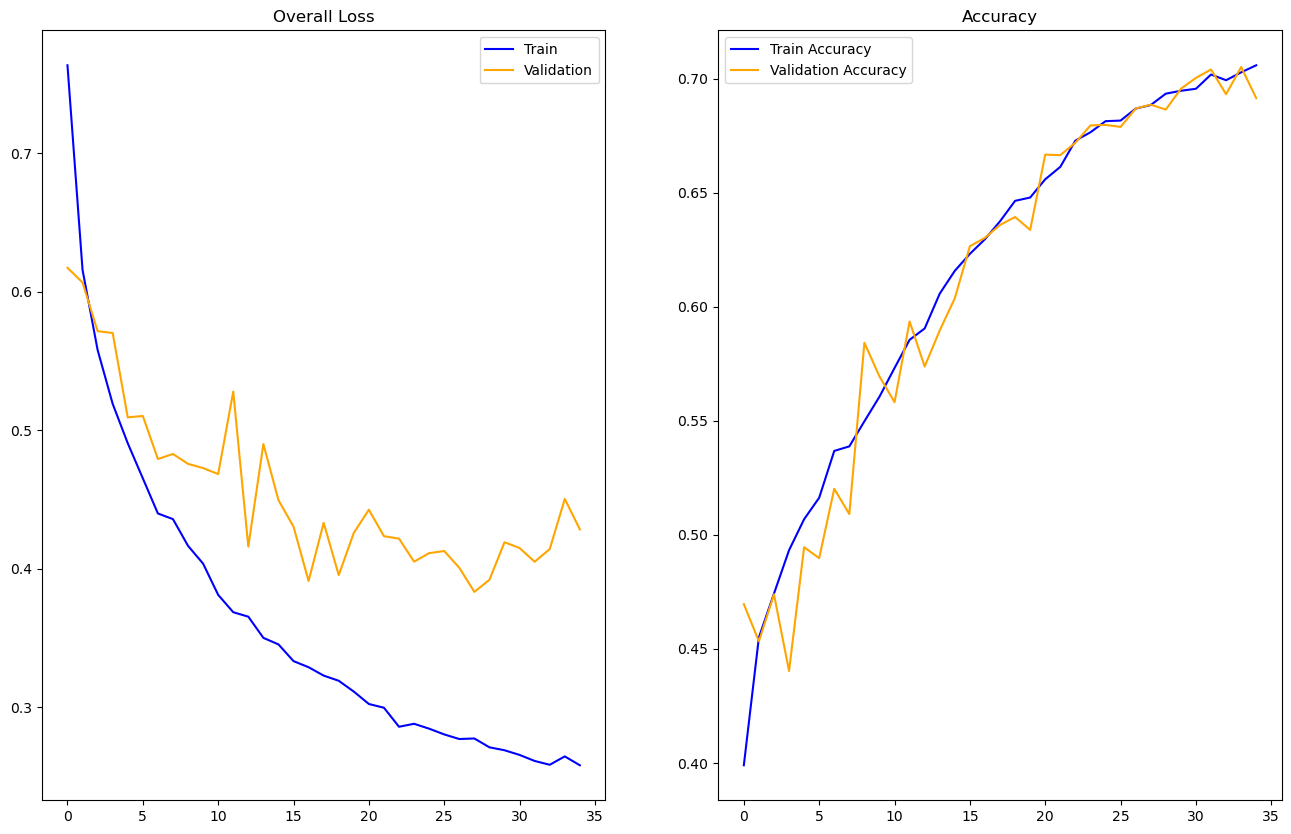

In [91]:
overall, accuracy = train(
    model=model,
    optimizer=optimizer,
    loss=loss_func,
    epochs=epochs,
    dataloader=dataloader,
    val_dataset=val_dataset,
    scheduler=scheduler,
    plot=True,
    show_progress=True,
    trial=None
)

In [92]:
model.eval()

ConvClassifier(
  (encoder): ConvEncoder(
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (block0): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=False)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.2, inplace=False)
    )
    (max_pool_block0): MaxPoolBlock(
      (max_pool): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=True)
      (bn): BatchNorm2d(

In [93]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [94]:
import seaborn as sns

In [95]:
def show_metrics(model, dataset, data_dir='./data/alzheimer/train'):
    classes = os.listdir(data_dir)

    output = model(dataset.X.to(model.device))
    predictions = torch.argmax(output, dim=1).to(model.device)
    accuracy = (predictions == dataset.y.to(model.device)).sum().item() / predictions.shape[0]

    print(f'Total Accuracy: {accuracy}\n')

    # choosing weighted because we want to calculate per class and then calculate the weighted sum since our labels are imbalanced
    average_policy = None

    # precision = tp / (tp + fp)
    print('Precision: ')
    precisions = precision_score(dataset.y.cpu().numpy(), predictions.cpu().numpy(), average=average_policy, zero_division=0)
    for class_idx in range(len(classes)):
        print(f'{classes[class_idx]}: {precisions[class_idx]}')
    print()

    # recall = tp / (tp + fn)
    print('Recall: ')
    recalls = recall_score(dataset.y.cpu().numpy(), predictions.cpu().numpy(), average=average_policy, zero_division=0)
    for class_idx in range(len(classes)):
        print(f'{classes[class_idx]}: {recalls[class_idx]}')
    print()

    g = sns.heatmap(confusion_matrix(dataset.y.cpu().numpy(), predictions.cpu().numpy()), annot=True, fmt='.3g', yticklabels=classes)

    g.set_xticklabels(labels=[f'{class_name}' for class_name in classes], rotation=60)

    plt.xlabel('Prediction')
    plt.ylabel('Truth')

In [96]:
from PIL import Image

In [97]:
test_data_dir = './data/alzheimer/test'
classes = os.listdir(test_data_dir)
class_to_idx = {}
for i in range(len(classes)):
    class_to_idx[classes[i]] = i

total_test_images = 0
for class_name in classes:
    total_test_images += len(os.listdir(f'{test_data_dir}/{class_name}'))

In [98]:
test_images = np.empty((total_test_images, 208, 176), dtype=np.uint8)
test_labels = np.empty(total_test_images, dtype=np.uint8)

In [99]:
image_idx = 0
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{test_data_dir}/{class_name}')):
        image_path = f'{test_data_dir}/{class_name}/{image_name}'
        test_images[image_idx] = np.array(Image.open(image_path)).astype(np.uint8)
        test_labels[image_idx] = class_to_idx[class_name]
        image_idx += 1

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

In [100]:
leftmost_pixel, uppermost_pixel = 16, 16
rightmost_pixel, bottommost_pixel = 159, 191

test_images = test_images[:, uppermost_pixel:bottommost_pixel+1, leftmost_pixel:rightmost_pixel+1]

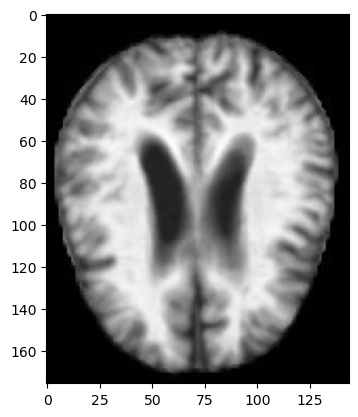

In [101]:
plt.imshow(test_images[test_labels == 1].mean(axis=0), cmap='gray')

In [102]:
test_dataset = AlzheimerDataset(test_images, test_labels)

Total Accuracy: 0.5754495699765442

Precision: 
MildDemented: 0.539568345323741
ModerateDemented: 0.36363636363636365
NonDemented: 0.6943942133815552
VeryMildDemented: 0.4739583333333333

Recall: 
MildDemented: 0.41899441340782123
ModerateDemented: 0.3333333333333333
NonDemented: 0.6
VeryMildDemented: 0.609375



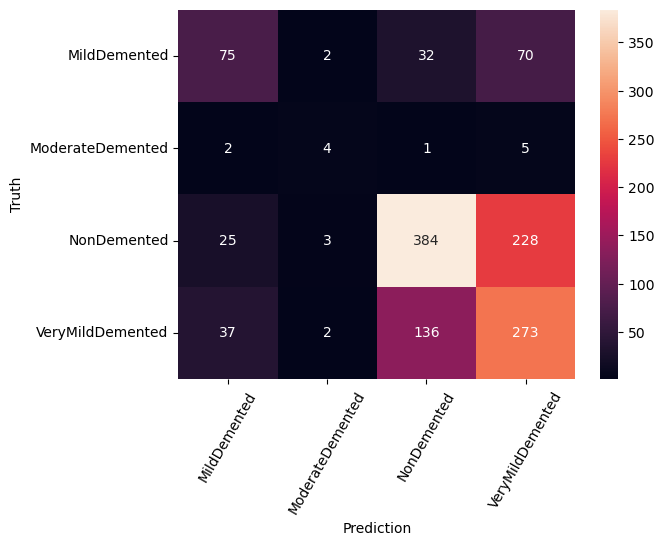

In [103]:
show_metrics(model, test_dataset)

Total Accuracy: 0.69140625

Precision: 
MildDemented: 0.4754944110060189
ModerateDemented: 0.5483870967741935
NonDemented: 0.7308970099667774
VeryMildDemented: 0.9183976261127597

Recall: 
MildDemented: 0.8722397476340694
ModerateDemented: 0.85
NonDemented: 0.873015873015873
VeryMildDemented: 0.3715486194477791



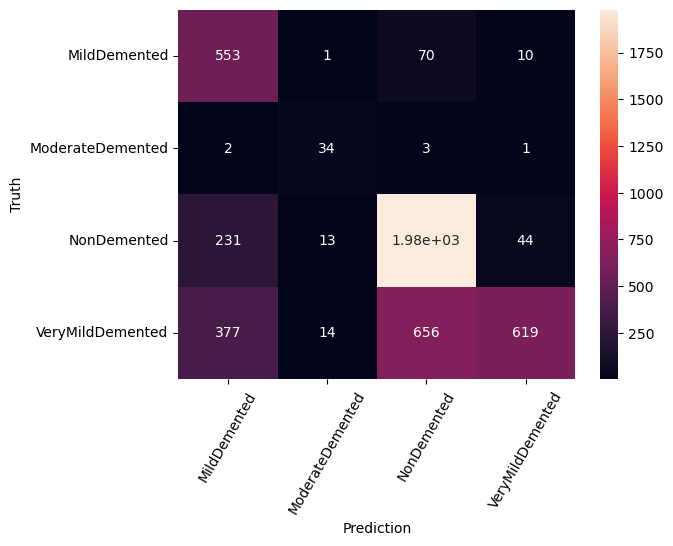

In [104]:
show_metrics(model, val_dataset)

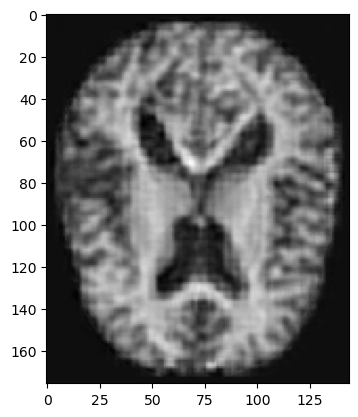

In [105]:
plt.imshow(images[-2], cmap='gray')

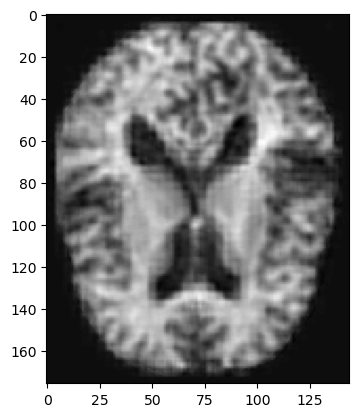

In [106]:
plt.imshow(images[images.shape[0]//2-2], cmap='gray')

In [107]:
import shutil
try:
    shutil.rmtree(f'./logs/classification/study-{current_study_id}')
except Exception as e:
    print(e)